загружаем необходимые библиотеки и модули

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook

from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout, Flatten, Input
from keras.optimizers import Adam

from bots.modules.awards import get_profit, get_target_q_learning
from bots.modules.player import Seller, Customer
from bots.modules.game import Game
from bots.modules.visualization import calculate_statistic

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


Функции для создания предсказательных моделей у игроков

In [3]:
def create_model(size_input=10, size_hidden=10):
    inp = Input(shape=(size_input,))
    hidden_1 = Dense(size_hidden, kernel_initializer='normal', activation='relu')(inp)
    hidden_2 = Dense(size_hidden, kernel_initializer='normal', activation='relu')(hidden_1)
    out = Dense(1, activation='linear')(hidden_2)

    model = Model(inputs=inp, outputs=out)
    model.compile(loss='mse', optimizer=Adam(lr=0.01), metrics=['mse'])
    return model


def seller_award(data):
    return get_target_q_learning(data, lambda_Q=0.5, weight_delta=0)[:, 0]

def customer_award(data):
    return get_target_q_learning(data, lambda_Q=0.5, weight_delta=0)[:, 1]

Создаём игроков: 2 продавца и 2 покупателя

In [4]:
sellers = [
    Seller([1.5, 11], create_model(), seller_award, alpha=10),
    Seller([1.5, 11], create_model(), seller_award, alpha=10),
]
customers = [
    Customer([0, 1], create_model(), customer_award, alpha=10),
    Customer([0, 1], create_model(), customer_award, alpha=10),
]

game = Game(sellers, customers)

# Имитация розыгрышей игры
Моделируем 200 раз по 10 игр. После каждых 10 игр дообучаем модели игроков, предсказывающие их ожидаемый выигрыш.

In [5]:
for _ in tqdm_notebook(range(200)):
    game.run(10, 10)

# Считаем статистики по полученным данным

Вот так можно посмотреть произвольный розыгрыш игры. На примере ниже показана последняя игра. <br/>
1 столбец - номер итерации, 2 - номер продавца, 3 - номер покупателя, 4 - тип автомобиля, 5 - цена, 6 - решение покупателя.

In [12]:
game.data_hist[-1]

array([[ 0. ,  0. ,  0. ,  1. , 11. ,  0. ],
       [ 0. ,  1. ,  1. ,  1. , 11. ,  0. ],
       [ 1. ,  0. ,  0. ,  1. , 11. ,  0. ],
       [ 1. ,  1. ,  1. ,  1. , 11. ,  0. ],
       [ 2. ,  0. ,  0. ,  1. , 11. ,  0. ],
       [ 2. ,  1. ,  1. ,  0. , 11. ,  0. ],
       [ 3. ,  0. ,  0. ,  1. , 11. ,  0. ],
       [ 3. ,  1. ,  1. ,  0. , 11. ,  0. ],
       [ 4. ,  0. ,  0. ,  1. , 11. ,  0. ],
       [ 4. ,  1. ,  1. ,  0. , 11. ,  0. ],
       [ 5. ,  0. ,  0. ,  1. , 11. ,  0. ],
       [ 5. ,  1. ,  1. ,  1. , 11. ,  0. ],
       [ 6. ,  0. ,  0. ,  0. ,  1.5,  0. ],
       [ 6. ,  1. ,  1. ,  0. , 11. ,  0. ],
       [ 7. ,  0. ,  0. ,  1. , 11. ,  1. ],
       [ 7. ,  1. ,  1. ,  0. , 11. ,  1. ],
       [ 8. ,  0. ,  0. ,  1. , 11. ,  0. ],
       [ 8. ,  1. ,  1. ,  0. , 11. ,  0. ],
       [ 9. ,  0. ,  0. ,  1. , 11. ,  1. ],
       [ 9. ,  1. ,  1. ,  1. , 11. ,  0. ],
       [10. ,  0. ,  0. ,  1. , 11. ,  1. ],
       [10. ,  1. ,  1. ,  1. , 11. ,  0. ],
       [11

Функция для вычисления статистик (количество сделок, доверие, честность, выигрыш)

In [13]:
statistics = calculate_statistic(game.data_hist, len(sellers))

/home/nnazarov/nni/asp/limon_market/bots/modules/visualization.py:23: RuntimeWarning: Mean of empty slice.
  return (data_[:, 1] < 5).mean()
/home/nnazarov/.pyenv/versions/3.6.3/envs/shad/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Статистика для первого продавца по последним 5 играм.

In [15]:
statistics['sellers'][0].tail()

,count_trade,part_honest,part_trust,award
1995,1,1.000000,0.071429,1.0
1996,6,1.000000,0.142857,4.0
1997,5,0.666667,0.222222,4.5
1998,4,0.571429,0.250000,13.0
1999,7,0.750000,0.294118,6.0


Графики честности первого продавца и доверия покупателей, с которыми он играл.

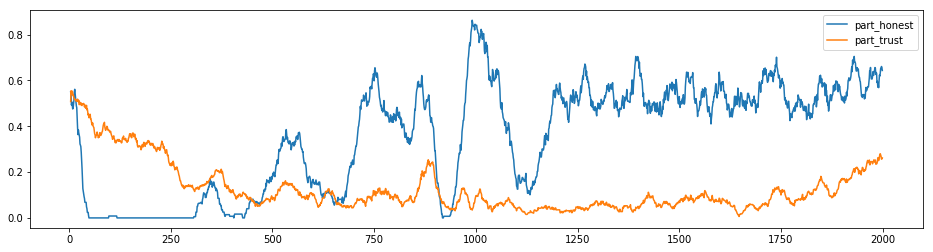

In [19]:
statistics['sellers'][0][['part_honest', 'part_trust']].rolling(20, min_periods=5).mean().plot(figsize=[16, 4]);